# Accidentes

In [1]:
from simpledbf import Dbf5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from dateutil.relativedelta import relativedelta
%matplotlib inline

In [2]:
from zipfile import ZipFile
import requests
from io import BytesIO
import os

In [3]:
def extract_accidents(dateyear, path="."):
    """
    Extrae información desde la base de datos de accidentes del INEGI
    a una fecha dada
    """
    # Dar formato al request
    year_complete = dateyear.strftime("%Y")
    year_2dig = dateyear.strftime("%y")
    web = ("http://www3.inegi.org.mx/contenidos"
           "/proyectos/registros/economicas/accidentes"
           "/microdatos/{year_complete}/atus_{year_2dig}_dbf.zip")
    web = web.format(year_complete=year_complete, year_2dig=year_2dig)
    
    req = requests.get(web)
    zip_io = ZipFile(BytesIO(req.content))
    
    absolute_path = os.path.realpath(path)
    # Warning: May overwrite existing information
    if not os.path.exists(absolute_path):
        os.mkdir(absolute_path)
    
    zip_io.extractall(path=absolute_path)
    
    return True

In [4]:
#ISO-8859-1
data_loc = Dbf5("data/ARCH14.DBF", codec="ISO-8859-1").to_dataframe()
data_loc.head()

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVE_LOC,NOM_LOC,AMBITO,LATITUD,LONGITUD,ALTITUD,Z1
0,01,Aguascalientes,001,Aguascalientes,0001,Aguascalientes,U,215247.362,1021745.768,1878,722250
1,01,Aguascalientes,001,Aguascalientes,0094,Granja Adelita,R,215218.749,1022224.710,1902,14
2,01,Aguascalientes,001,Aguascalientes,0096,Agua Azul,R,215301.522,1022125.639,1861,37
3,01,Aguascalientes,001,Aguascalientes,0100,Rancho Alegre,R,215116.556,1022221.884,1879,10
4,01,Aguascalientes,001,Aguascalientes,0102,Los Arbolitos [Rancho],R,214648.650,1022126.261,1861,7


In [5]:
data_loc.LONGITUD[0]

'1021745.768'

In [6]:
# "LATITUD", "LONGITUD", "ALTITUD" son columnas de caracteres => convertirlas a float
# Si encuentra un error, 'coerce' lo convierte en un np.nan
cols_to_float = ["LATITUD", "LONGITUD", "ALTITUD", "CVE_ENT", "CVE_MUN"]
for col in cols_to_float:
    data_loc[col] = pd.to_numeric(data_loc[col], errors="coerce")

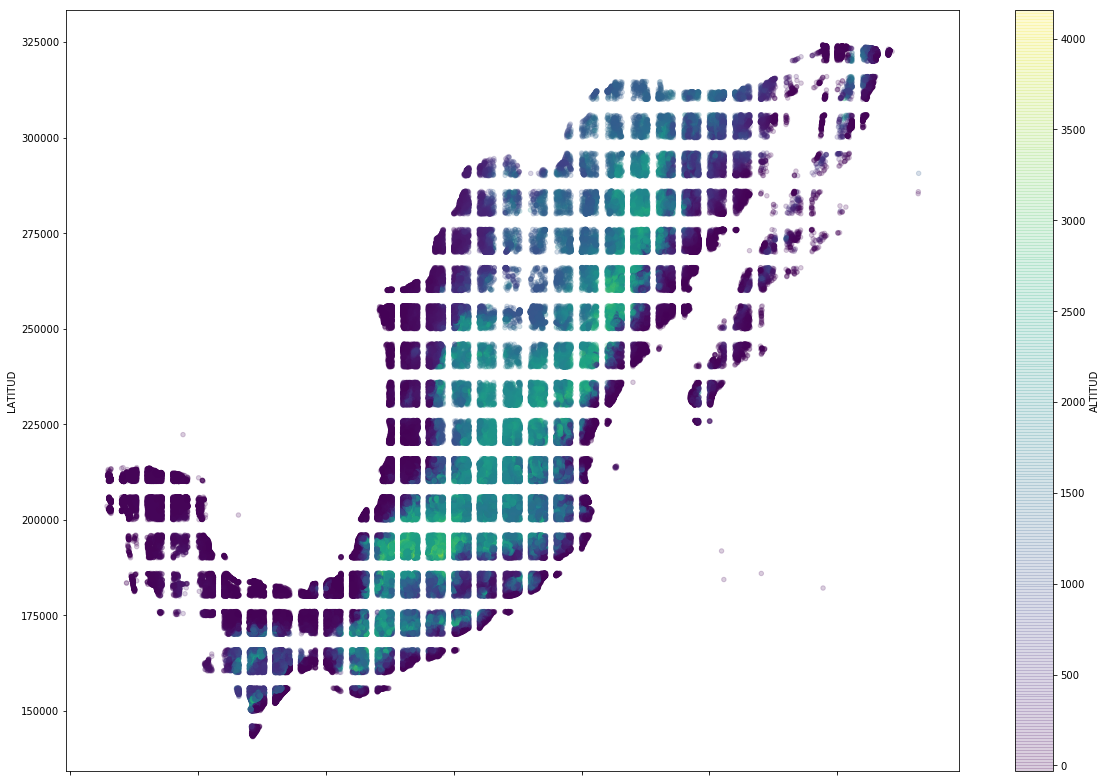

In [7]:
# Grafica datos en data/ARCH14.DBF
data_loc.plot.scatter(x="LONGITUD", y="LATITUD", alpha=0.2,
                      c="ALTITUD", cmap=plt.get_cmap("viridis"), figsize=(20, 14));

### Extraer información de Accidentes

In [98]:
# Extrae información de INEGI desde el año 1997 hasta 2015
currdate = datetime(1997, 1, 1)
while currdate.year <= 2015:
    print(currdate.year, end="\r")
    extract_accidents(currdate, path="./data")
    currdate += relativedelta(years=1)
print("\r")
print("Done")

2015
Done


In [8]:
files = [f for f in os.listdir("data/") if f.lower().endswith("dbf") and "ARCH" not in f]
files

['atus2013.dbf',
 'ATUS_00.DBF',
 'ATUS_01.DBF',
 'ATUS_02.DBF',
 'ATUS_03.DBF',
 'ATUS_04.DBF',
 'ATUS_05.DBF',
 'ATUS_06.DBF',
 'ATUS_07.dbf',
 'ATUS_08.dbf',
 'ATUS_09.dbf',
 'ATUS_10.DBF',
 'ATUS_11.DBF',
 'ATUS_2012.dbf',
 'ATUS_97.DBF',
 'ATUS_98.DBF',
 'ATUS_99.DBF',
 'bdatus14.dbf',
 'bdatus15.dbf']

In [113]:
# Lee base de datos de los archivos extraídos desde ./data/accidents
accdb = pd.DataFrame()
for file in files[1:6]:
    print(file, end="\r")
    path = "data/{}".format(file)
    infile = Dbf5(path).to_dataframe()
    accdb = accdb.append(infile)
print()
print("Done...")

ATUS_04.DBF
Done...


In [114]:
# 0: Se fugó; 99: no especificado
accdb = accdb.query("EDAD not in [0, 99]")
accdb.shape

(1773844, 42)

In [115]:
accdb.head()

,EDO,MES,ANIO,MPIO,HORA,MINUTOS,DIA,DIASEMANA,URBANA,SUBURBANA,...,PASAMUERTO,PASAHERIDO,PEATMUERTO,PEATHERIDO,CICLMUERTO,CICLHERIDO,OTROMUERTO,OTROHERIDO,NEMUERTO,NEHERIDO
1,1,1,2000,1,1,40,1,6,1,0,...,0,0,0,1,0,0,0,0,0,0
2,1,1,2000,1,2,20,1,6,1,0,...,0,2,0,0,0,0,0,0,0,0
3,1,1,2000,1,2,20,1,6,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,2000,1,3,40,1,6,1,0,...,0,1,0,0,0,0,0,0,0,0
5,1,1,2000,1,5,10,1,6,1,0,...,0,1,0,0,0,0,0,0,0,0


In [116]:
accdb.columns

Index(['EDO', 'MES', 'ANIO', 'MPIO', 'HORA', 'MINUTOS', 'DIA', 'DIASEMANA',
       'URBANA', 'SUBURBANA', 'TIPACCID', 'AUTOMOVIL', 'CAMPASAJ', 'MICROBUS',
       'PASCAMION', 'OMNIBUS', 'TRANVIA', 'CAMIONETA', 'CAMION', 'TRACTOR',
       'FERROCARRI', 'MOTOCICLET', 'BICICLETA', 'OTROVEHIC', 'CAUSAACCI',
       'CAPAROD', 'SEXO', 'ALIENTO', 'CINTURON', 'EDAD', 'CONDMUERTO',
       'CONDHERIDO', 'PASAMUERTO', 'PASAHERIDO', 'PEATMUERTO', 'PEATHERIDO',
       'CICLMUERTO', 'CICLHERIDO', 'OTROMUERTO', 'OTROHERIDO', 'NEMUERTO',
       'NEHERIDO'],
      dtype='object')

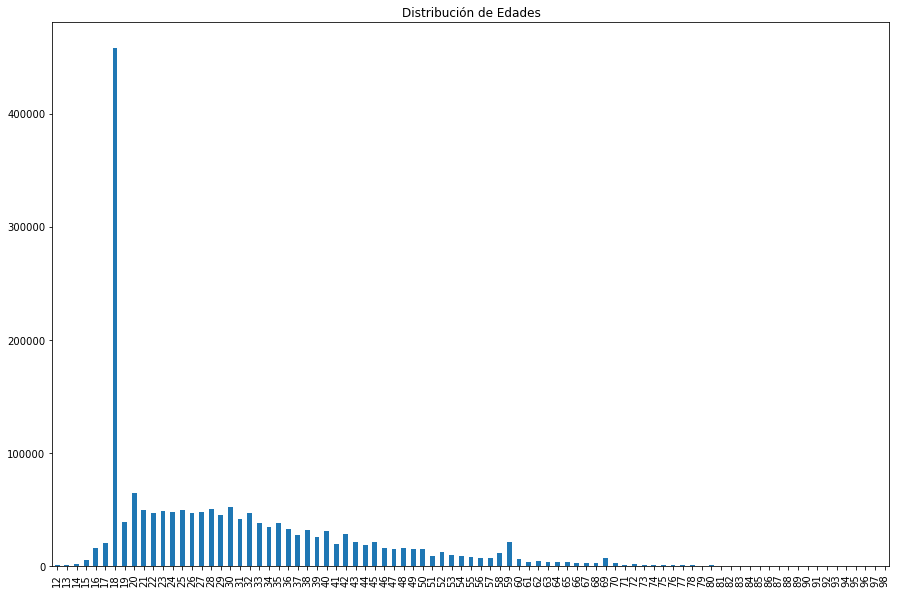

In [117]:
fig, ax = plt.subplots(figsize=(15,10))
accdb.EDAD.value_counts(sort=False).plot(kind="bar", ax=ax, title="Distribución de Edades")

In [119]:
loc_grouped = data_loc.groupby(["CVE_ENT", "NOM_ENT", "NOM_MUN", "CVE_MUN"]).mean().reset_index()
loc_grouped.head()

,CVE_ENT,NOM_ENT,NOM_MUN,CVE_MUN,LATITUD,LONGITUD,ALTITUD
0,1,Aguascalientes,Aguascalientes,1,215108.081532,1.021676e+06,1914.924000
1,1,Aguascalientes,Asientos,2,220797.569370,1.019491e+06,2033.214286
2,1,Aguascalientes,Calvillo,3,215483.380616,1.024272e+06,1823.693811
3,1,Aguascalientes,Cosio,4,222140.973851,1.021665e+06,1969.724138
4,1,Aguascalientes,El Llano,10,215362.386537,1.019982e+06,2022.181818


In [120]:
# Accidentes agrupados por localidad
accdb_loc = accdb.merge(loc_grouped, left_on="MPIO", right_on="CVE_MUN", how="left")
accdb_loc.head()

,EDO,MES,ANIO,MPIO,HORA,MINUTOS,DIA,DIASEMANA,URBANA,SUBURBANA,...,OTROHERIDO,NEMUERTO,NEHERIDO,CVE_ENT,NOM_ENT,NOM_MUN,CVE_MUN,LATITUD,LONGITUD,ALTITUD
0,1,1,2000,1,1,40,1,6,1,0,...,0,0,0,1,Aguascalientes,Aguascalientes,1,215108.081532,1.021676e+06,1914.924000
1,1,1,2000,1,1,40,1,6,1,0,...,0,0,0,2,Baja California,Ensenada,1,310072.319428,1.158154e+06,332.330988
2,1,1,2000,1,1,40,1,6,1,0,...,0,0,0,3,Baja California Sur,Comondu,1,252993.926716,1.115095e+06,142.349890
3,1,1,2000,1,1,40,1,6,1,0,...,0,0,0,4,Campeche,Calkini,1,202129.325540,9.002503e+05,12.603175
4,1,1,2000,1,1,40,1,6,1,0,...,0,0,0,5,Coahuila de Zaragoza,Abasolo,1,270871.875952,1.011854e+06,431.404762


In [128]:
# Resumen del número de accidentes 
accdb_summ = accdb_loc.groupby("NOM_MUN").agg({"EDO":"count", "LONGITUD":"mean", "LATITUD":"mean"}).reset_index()
accdb_summ.sort_values("EDO", ascending=False, inplace=True)

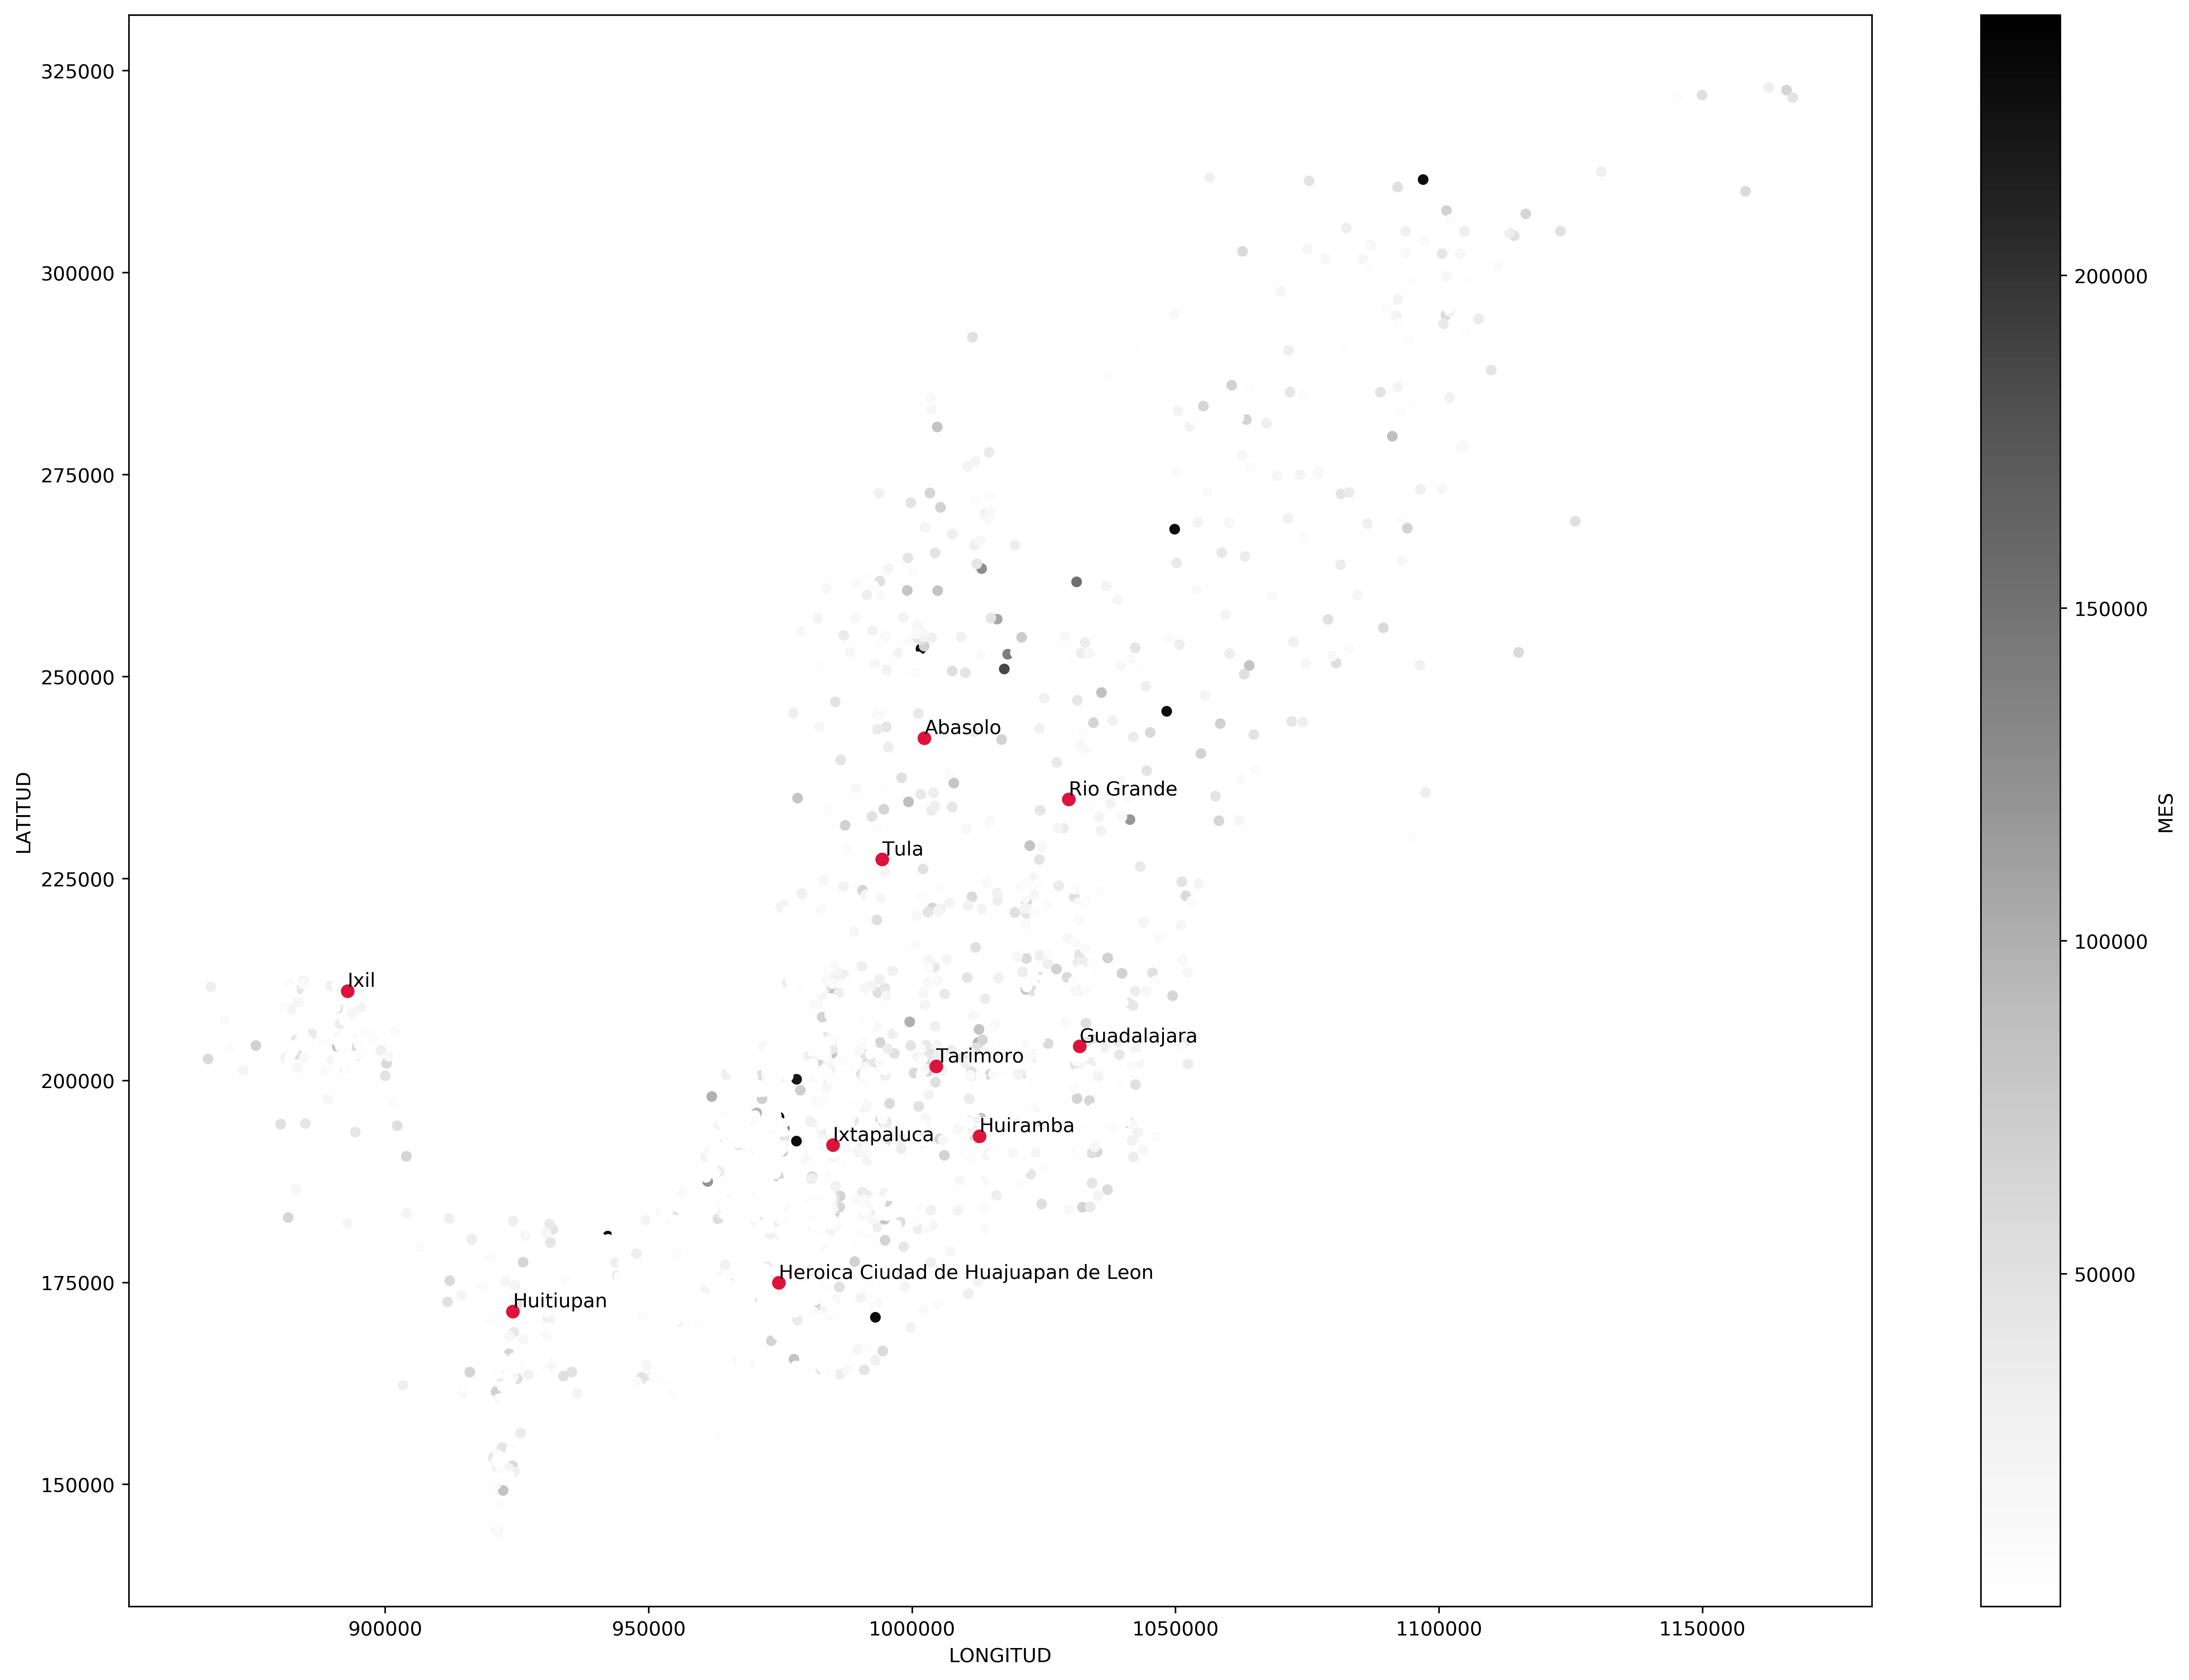

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15), dpi=400)
accdb_summ.plot("LONGITUD", "LATITUD", kind="scatter", c="MES", ax=ax)
for row in accdb_summ.values[:10]:
    plt.text(row[2], row[3], row[0], verticalalignment="bottom")
    plt.scatter(row[2], row[3], c="crimson")

In [150]:
acc18 = accdb[["EDO", "EDAD"]].query("EDAD == 18")

In [ ]:
acc18.merge(data_loc, left_on="EDO", right_on="CVE_ENT", )